In [1]:
import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt 

import time 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
# !pip install torchsummary
import torchsummary

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets,models,transforms,utils
# from torchvision.transforms import v2


import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split

C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
root_path = './dataset'
df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
label_dict = {
    "H1":0,
    "H2":1,
    "H3":2,
    "H5":3,
    "H6":4,
}
for key in label_dict:
    img_path = os.path.join(root_path, key)
    jpg_list = glob(img_path+'/*.jpg')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":key, "class_id":label_dict[key]}, index=[1])
        df = pd.concat([df, new_data], ignore_index=True)

df[["path"]] = df[["path"]].astype(str)
df[["label"]] = df[["label"]].astype(str)
df[["class_id"]] = df[["class_id"]].astype(int)

In [3]:
df.head()

,path,label,class_id
0,./dataset\H1\H1_100a_1.jpg,H1,0
1,./dataset\H1\H1_100a_2.jpg,H1,0
2,./dataset\H1\H1_100a_3.jpg,H1,0
3,./dataset\H1\H1_100a_4.jpg,H1,0
4,./dataset\H1\H1_100a_5.jpg,H1,0


(array([4404.,    0., 2334.,    0.,    0.,  819.,    0.,  818.,    0.,
         739.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

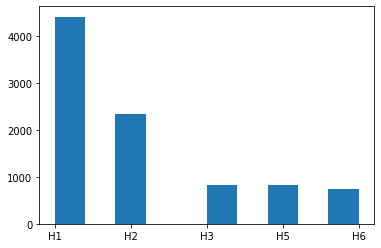

In [4]:
plt.hist(df['label'])

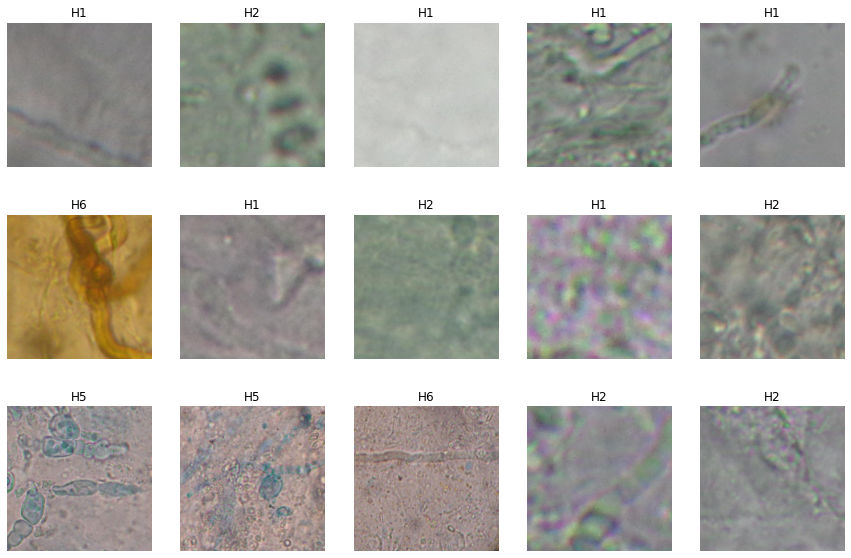

In [5]:
show_imgs = 15
idx = np.random.randint(0, len(df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(df.loc[idx[i]]['label'])
    ax.set_axis_off()

In [6]:
import torchvision.transforms as transforms

#训练数据集转换
train_transforms = transforms.Compose([
    #输入图像调整为256x256
    transforms.Resize(256),
    
    #调整后的图像中随机裁剪出224x224的区域
    transforms.RandomResizedCrop(size=(224, 224)),
    
    #以50%概率对图像进行水平翻转
    transforms.RandomHorizontalFlip(p=0.5),
    
    #以50%概率对图像进行垂直翻转
    transforms.RandomVerticalFlip(p=0.5),
    
    #在[-10,10]度范围内随机旋转，(0.1,0.)随机水平和垂直平移比例 ， (0.9,1.1)控制图像缩放范围
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    
    #图像转换成PyTorch张量
    transforms.ToTensor(),
    
    transforms.Lambda(lambda x: x.to(torch.float32)),  # 使用自定义函数将张量转换为 float32 类型
    
    #以50%概率对图像进行随机擦除
    transforms.RandomErasing(p=0.5, scale=(0.1, 0.15)),
    
    
    #对图像进行标准化处理，使用给定的均值和方差
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#测试集转换
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(torch.float32)),  # 使用自定义函数将张量转换为 float32 类型
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        #使用数据增强、将PIL图像转换为torch张量
        self.transforms_ = transforms_
        
    def __len__(self):
#         返回数据集长度
        return len(self.df)
    
    def __getitem__(self, index):
        #获取图像路径
        image_path = self.df.iloc[index]['path']
        #使用PIL库打开图像并转换为RGB格式
        img = Image.open(image_path).convert("RGB")
        #用预定义的转换操作到图像
        transformed_img = self.transforms_(img)
        #获取图像对应类别标签
        class_id = self.df.iloc[index]['class_id']
        #返回转换后的图像以及对应类别标签
        return transformed_img, class_id

In [8]:
# 指定要使用的GPU编号（这里假设使用GPU编号为0）
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#检查是否有可用的GUP
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
#根据设备选择合适的工作线程数量
num_workers = 2 if device=='cuda' else 4 # fixed by kaggle notebook
#将数据集划分为训练集和验证集（测试集）
train_df, val_df = train_test_split(df,test_size=0.2,random_state=2023)
#创建训练集和验证机的自定义数据集对象
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)

#批处理大小
BATCH_SIZE = 1

#shuffe = True 每个epoch开始前，对训练集进行洗牌
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)

#验证集的数据加载器
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [9]:
print(f'train data:{len(train_df)}')
print(f'val data:{len(val_df)}')

train data:7291
val data:1823


In [10]:
class_size = 5

model =models.efficientnet_b1(weights='DEFAULT')
# 将模型的分类器部分修改为适应新的类别数   2560是上一层的size
model.classifier[1] = torch.nn.Linear(1280,class_size)

# 生成模型的输出形状，这里使用随机输入张量进行测试
model(torch.randn((16,3,256,256))).shape

torch.Size([16, 5])

In [11]:
#开始训练
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # 数据集大小
    num_batches = len(dataloader) # 每个epoch的批次数
    model.train() #模型设置为训练模式
    epoch_loss = 0.0  #初始化epoch损失
    epoch_correct = 0  #初始化epoch正确预测的样本数
    
    for (data_,target_) in dataloader:
        target_ = target_.type(torch.LongTensor) #label标签
        data_, target_ = data_.to(device), target_.to(device) #传到GPU上
        
        #清空优化器的梯度信息
        optimizer.zero_grad()
        
        #向前传播
        outputs = model(data_)
        
        #计算损失
        loss = criterion(outputs,target_)
        
        #反向传播
        loss.backward()
        
        #优化模型
        optimizer.step()
        
        #统计损失信息
        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
        
    lr_scheduler.step() #更新学习率
        
    return epoch_correct/size, epoch_loss/num_batches

#开始测试
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # 数据集大小（样本数）
    num_batches = len(dataloader) # 每个epoch的批次数
    epoch_loss = 0.0  #初始化epoch损失
    epoch_correct = 0  #初始化epoch正确预测的样本数
    with torch.no_grad():
        #进入评估模式，不启用梯度计算
        model.eval()
        for (data_,target_) in dataloader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)

            # 前向传播
            outputs = model(data_)
            
            # 计算损失
            loss = criterion(outputs,target_)
            
            #统计损失信息
            epoch_loss = epoch_loss + loss.item()
        
            #预测类别
            _,pred = torch.max(outputs,dim=1)
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    return  epoch_correct/size, epoch_loss/num_batches

In [ ]:
model.to(device) #模型移动到GPU
EPOCHS = 50 #迭代次数

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
#定义损失计算方法
criterion  = nn.CrossEntropyLoss() #交叉熵损失


#优化器，用于更新模型参数
learning_rate = 0.0001 #学习率
momentum = 0.9 #动量，优化算法的一个参数，帮助加速模型收敛，有助于更新参数的时候减少震荡
weight_decay = 0.1  #权重衰减，优化算法中队权重参数进行衰减或正则化的一种手段。优化过程中队权重施加惩罚，防止过拟合

# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) #AdamW优化器
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

#学习率调整器
lr_milestones = [7, 14, 21, 28, 35] #学习率下降的里程碑
#多步学习率调整器
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)

#提前终止 配置
patience = 5   #容忍多少个epoch没有提升
counter = 0    #统计没有提升的epoch数量
best_loss = np.inf  #初始化最佳验证集上的损失为无穷大

for epoch in tqdm(range(EPOCHS)):
    
    #训练模型 ， 并返回训练集的准确率和损失
    train_acc, train_loss,  = train(train_loader, model, criterion, optimizer, multi_step_lr_scheduler)
    
    #验证集上测试模型，并返回验证集的准确率和损失
    val_acc, val_loss = test(val_loader, model, criterion)
    
    #打印当前epoch的训练和验证信息以及当前学习率
    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} \
    Learning Rate: {optimizer.param_groups[0]["lr"]}')
    
    #记录训练和验证集上的准确率和损失
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    
    #保存最新模型参数
    torch.save(model.state_dict(), "last.pth")
    
    #保存验证集上损失更低的模型参数，重置计数器和最佳损失值
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
        
    #如果连续patience个epoch都没有验证集上的损失更低，则提前结束训练
    if counter >= patience:
        print("Earlystop!")
        break


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]